In [16]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.applications.resnet50 import preprocess_input

Descargo modelo de detección de rostros

In [17]:
import urllib.request

# URL del archivo que quieres descargar
url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

# Ruta donde deseas guardar el archivo
file_path = "models/haarcascade_frontalface_default.xml"

# Descargar el archivo
urllib.request.urlretrieve(url, file_path)

print("Archivo descargado correctamente.")

Archivo descargado correctamente.


Imagen de prueba

In [18]:
# Ruta de la imagen
img_path = r"images/imagenes_MVP\WhatsApp Image 2024-10-21 at 21.03.41.jpeg"

# Leer la imagen
img = cv2.imread(img_path)

In [19]:
img

array([[[248, 200, 148],
        [248, 200, 148],
        [247, 199, 147],
        ...,
        [204, 205, 201],
        [205, 206, 202],
        [206, 207, 203]],

       [[248, 200, 148],
        [248, 200, 148],
        [247, 199, 147],
        ...,
        [204, 205, 201],
        [205, 206, 202],
        [205, 206, 202]],

       [[248, 200, 148],
        [247, 199, 147],
        [247, 199, 147],
        ...,
        [204, 205, 201],
        [205, 206, 202],
        [205, 206, 202]],

       ...,

       [[149, 140, 143],
        [155, 148, 151],
        [146, 141, 143],
        ...,
        [114, 113, 115],
        [134, 133, 135],
        [133, 132, 134]],

       [[141, 134, 137],
        [145, 138, 141],
        [144, 139, 141],
        ...,
        [118, 117, 119],
        [128, 127, 129],
        [133, 132, 134]],

       [[151, 144, 147],
        [138, 133, 135],
        [143, 138, 140],
        ...,
        [125, 124, 126],
        [118, 117, 119],
        [117, 116, 118]]

Detección y recorte de rostros

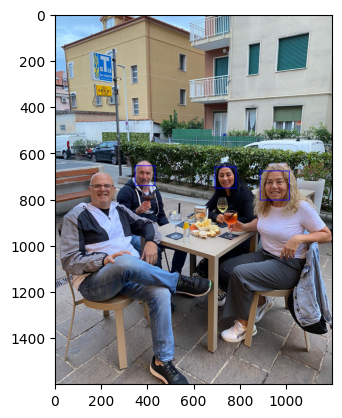

In [20]:
# Carga el clasificador Haar Cascade
face_cascade = cv2.CascadeClassifier('models/haarcascade_frontalface_default.xml')

# Convierte la imagen a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
gray = cv2.equalizeHist(gray)
# Detecta los rostros
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=70, minSize=(40, 40))
# Ajuste los parámetros para que no detecte todo como una cara sin dejar ninguna afuera
# Dibuja rectángulos alrededor de las caras detectadas
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Muestra la imagen con los rostros detectados
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Defino una función para preprocesamiento de los rostros

In [23]:
# Definir la función para preprocesar la cara
def preprocess_face(face_img):
    # Redimensionar la cara al tamaño requerido por el modelo
    face_resized = cv2.resize(face_img, (224, 224))
    
    # Convertir la imagen a formato array y preprocesar (según el modelo)
    face_array = np.array(face_resized)
    
    # Expandir las dimensiones para que tenga el formato (1, 224, 224, 3)
    face_array = np.expand_dims(face_array, axis=0)
    
    # Aplicar la preprocesación de ResNet50
    face_preprocessed = preprocess_input(face_array)
    
    return face_preprocessed

Usar modelos .pd 

In [22]:
model_path = "models/ResNet50_classification_model"
custom_model = keras.layers.TFSMLayer(model_path, call_endpoint='serving_default')

In [24]:
names = ["1.niños", "2.adolescentes", "3.jovenes_adultos", "4.adultos", "5.adultos_mayores", "6.tercera_edad"]

{'output_0': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.00511124, 0.02622214, 0.03020995, 0.02623943, 0.13328075,
        0.77893645]], dtype=float32)>}


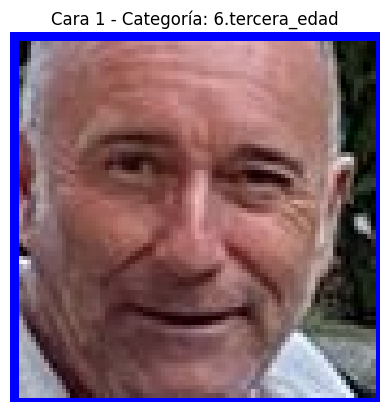

{'output_0': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.07732845, 0.37501654, 0.11006765, 0.18610026, 0.13327263,
        0.1182144 ]], dtype=float32)>}


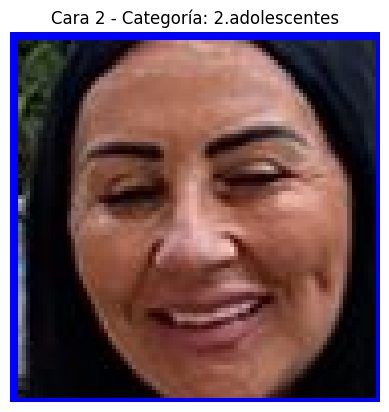

{'output_0': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.11043916, 0.16403586, 0.09885876, 0.06906807, 0.12561075,
        0.4319874 ]], dtype=float32)>}


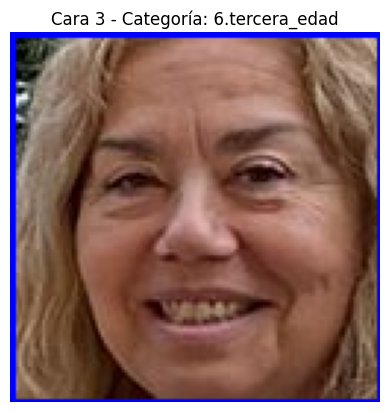

In [31]:
# Detectar y procesar las caras
for i, (x, y, w, h) in enumerate(faces):
    # Recortar la cara de la imagen original
    face = img[y:y+h, x:x+w]

    # Preprocesar la cara para hacer predicciones
    face_preprocessed = preprocess_face(face)  # Asegúrate de normalizar y ajustar el tamaño correctamente
    face_preprocessed = np.expand_dims(face_preprocessed, axis=0)  # Añadir una dimensión para batch_size=1

    # Hacer la predicción con el modelo TFSMLayer
    prediction_dict = custom_model(face_preprocessed)  # El modelo devuelve un diccionario
    prediction = prediction_dict['output_0']  # Extraer el tensor de probabilidades
    prediction = prediction.numpy()  # Convertir a un array de numpy

    # Obtener el índice de la clase con mayor probabilidad
    predicted_class = np.argmax(prediction[0])  # Como prediction tiene forma (1, 6), seleccionamos la primera fila

    # Obtener el nombre de la categoría predicha
    predicted_category = names[predicted_class]  # Mapear el índice a la etiqueta

    # Mostrar la cara usando matplotlib
    plt.figure()
    print(custom_model(face_preprocessed))
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB
    plt.title(f'Cara {i+1} - Categoría: {predicted_category}')
    plt.axis('off')  # Ocultar los ejes
    plt.show()


Para usar modelos .keras

In [32]:
# Cargar el modelo guardado
custom_model = load_model("models/model_VGG16.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
[[0.022769 0.000073 0.000131 0.976957 0.000025 0.000045]]


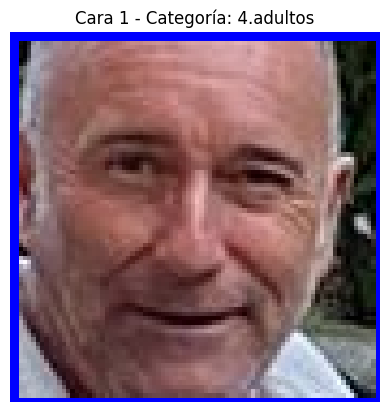

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
[[0.01045  0.00031  0.888319 0.099621 0.000626 0.000674]]


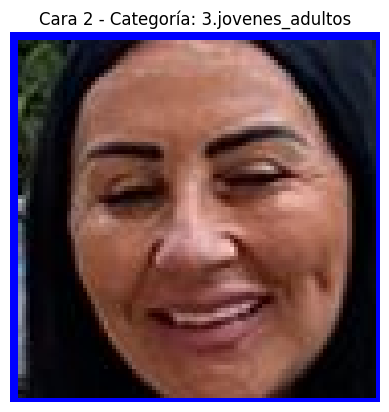

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
[[0.003962 0.421066 0.396701 0.116707 0.047838 0.013726]]


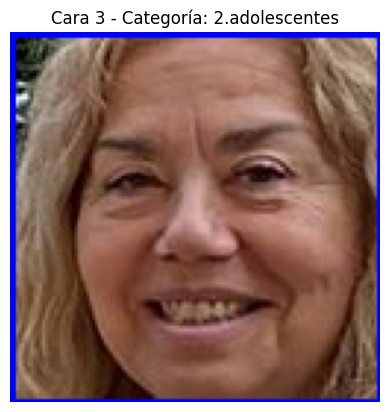

In [35]:
np.set_printoptions(suppress=True, precision=6)
# Detectar y procesar las caras
for i, (x, y, w, h) in enumerate(faces):
    # Recortar la cara de la imagen original
    face = img[y:y+h, x:x+w]

    # Preprocesar la cara para hacer predicciones
    face_preprocessed = preprocess_face(face)
    #print(face_preprocessed)
    
    
    # Hacer la predicción con el modelo
    prediction = custom_model.predict(face_preprocessed)
    
    # Obtener la clase predicha (categoría) con el índice de mayor probabilidad
    predicted_class = np.argmax(prediction, axis=1)[0]  # Obtener el índice de la clase
    
    # Obtener el nombre de la categoría predicha
    predicted_category = names[predicted_class]

    # Mostrar la cara usando matplotlib
    plt.figure()
    print(custom_model.predict(face_preprocessed))
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB
    plt.title(f'Cara {i+1} - Categoría: {predicted_category}')
    plt.axis('off')  # Ocultar los ejes
    plt.show()

---

[[[[-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   ...
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]]

  [[-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   ...
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]]

  [[-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   ...
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]]

  ...

  [[-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   ...
   [ -96.939 -109.779   87.32 ]
   [-102.939 -115.779  124.32 ]
   [-103.939 -116.779  131.32 ]]

  [[-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   ...
   [-102.939 -115.779  124.32 ]
   [-103.939 -116.779  130.32 ]
   [-103.939 -116.779 

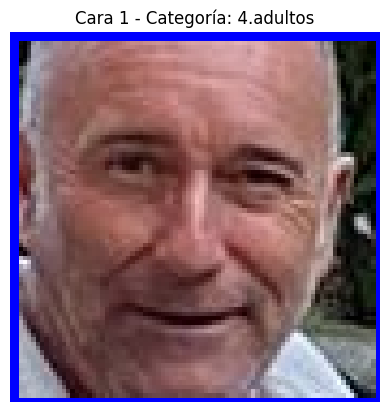

Imagen de la cara 1 guardada en cara_1.json en formato JSON.
[[[[-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   ...
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]]

  [[-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   ...
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]]

  [[-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   ...
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]]

  ...

  [[-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   ...
   [-102.939 -115.779   66.32 ]
   [-103.939 -116.779  117.32 ]
   [-103.939 -116.779  131.32 ]]

  [[-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   [-103.939 -116.779  131.32 ]
   ...
   [-103.939 -116.779  11

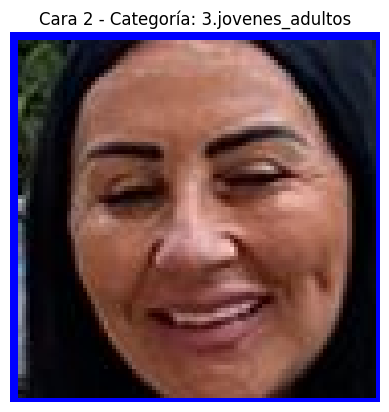

Imagen de la cara 2 guardada en cara_2.json en formato JSON.
[[[[-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]
   ...
   [-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]]

  [[-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]
   ...
   [-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]]

  [[-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]
   ...
   [-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]]

  ...

  [[-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]
   [-103.939    -116.779     131.32    ]
   ...
   [  -8.939003  -44.779     -25.68  

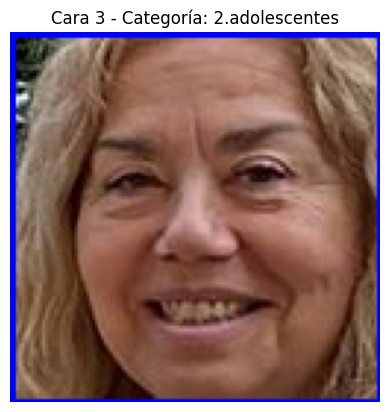

Imagen de la cara 3 guardada en cara_3.json en formato JSON.


In [ ]:
import json
# Detectar y procesar las caras
for i, (x, y, w, h) in enumerate(faces):
    # Recortar la cara de la imagen original
    face = img[y:y+h, x:x+w]
    
    # Preprocesar la cara para hacer predicciones
    face_preprocessed = preprocess_face(face)
    # print(face_preprocessed)
    
    # Hacer la predicción con el modelo
    prediction = custom_model.predict(face_preprocessed)
    
    # Obtener la clase predicha (categoría) con el índice de mayor probabilidad
    predicted_class = np.argmax(prediction, axis=1)[0]  # Obtener el índice de la clase
    
    # Obtener el nombre de la categoría predicha
    predicted_category = names[predicted_class]
    
    # Mostrar la cara usando matplotlib
    plt.figure()
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB
    plt.title(f'Cara {i+1} - Categoría: {predicted_category}')
    plt.axis('off')  # Ocultar los ejes
    plt.show()
    
    # Convertir la imagen de la cara en una lista de listas para guardar en formato JSON
    face_json_format = face.tolist()
    
    # Crear la estructura en JSON
    face_data = {
        "instances": [face_json_format]
    }
    
    # Guardar el archivo JSON
    json_filename = f'cara_{i+1}.json'
    with open(json_filename, 'w') as json_file:
        json.dump(face_data, json_file)
        
    print(f"Imagen de la cara {i+1} guardada en {json_filename} en formato JSON.")
